# Data Challenge 1

## Background:
The goal of this data challenge is to predict the price of airline tickets based on various features such as the date of the journey, source, destination, route, departure time, arrival time, duration, total stops, and additional information.

## Tasks:
1. **Task 1**: Preprocess Data: Analyze and preprocess the data to ensure suitability for analysis and modeling through exploratory data analysis (EDA).
2. **Task 2**: Feature Engineering: Handle missing values, convert categorical variables into numerical representations, and perform feature engineering to extract useful information.
3. **Task 3**: Exploratory Data Analysis (EDA): Conduct EDA on the newly created data to select relevant features.
4. **Task 4**: Regression Model Development (All Features): Develop a regression model using all features to predict airline ticket prices using the provided training dataset.
5. **Task 5**: Regression Model Development (Best Features):
   - **Trial 1**: Test with top features based on correlation and importance.
   - **Trial 2**: Test with top features based on correlation and importance, and remove outliers.
   - **Trial 3**: Test with fewer top features based on correlation and importance.
6. **Task 6**: Generate Model: Use the provided test dataset to generate model 

## Dataset:
Provided with a dataset containing information about airline tickets. We will use `train_data` and `train_labels` to train your model, where `train_data` contains features (like Airline, Date_of_Journey, etc.) and `train_labels` contains corresponding target values (Price in this case). 
We’ll use the trained model to predict a set of labels based on `test_data`. 


## Submission:
- **Implementation**: Jupyter notebook (e.g., `DC1.ipynb`) containing data exploration, preprocessing, model training, and evaluation steps. Clearly documenting my process, including feature selection, data preprocessing techniques, model selection, hyperparameter tuning, and evaluation metrics.
- **Predictions for the target on the test set**: CSV file (e.g., `airline_price_predictions.csv`) containing the predicted prices for the airline tickets in the test dataset.


In [1]:
import sys
sys.path.append("./modules")
from eda.eda import EDAAnalyzer
from ElasticNet.ElasticNetModel import ElasticNetModel
from feature_engineering.feature_engineering import FeatureEngineer
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from cluster_algo.kmeans.kmeans_clustering import KMeansClustering

### Required input data

In [2]:
oil_df = pd.read_csv("./DC1Data/oil_prices.csv", parse_dates=['Date_of_Journey'], date_format='%d/%m/%Y')
airline_df = pd.read_csv("./DC1Data/airlineData.csv")
destinationAirportDetails_df = pd.read_csv("./DC1Data/destinationAirportDetails.csv")
sourceAirportDetails_df = pd.read_csv("./DC1Data/sourceAirportDetails.csv")
X = pd.read_csv("./DC1Data/train_data.csv")
Y = pd.read_csv("./DC1Data/train_labels.csv")
data = pd.concat([X,Y],axis=1)

## Task 1
 * Before training a regression model, we analyze and preprocess the data to ensure that its suitable for analysis and modeling with EDA.

In [3]:
eda_analyzer = EDAAnalyzer(data)
eda_analyzer.display_head()

Airline Date_of_Journey  Source Destination  \
0        Jet Airways      12/03/2019  Mumbai   Hyderabad   
1        Jet Airways       9/05/2019   Delhi      Cochin   
2           SpiceJet      24/04/2019   Delhi      Cochin   
3  Multiple carriers      21/03/2019   Delhi      Cochin   
4          Air India      24/06/2019   Delhi      Cochin   

                   Route Dep_Time  Arrival_Time Total_Stops  \
0  BOM ? VNS ? DEL ? HYD    06:30         16:35     2 stops   
1        DEL ? BOM ? COK    11:30  12:35 10 May      1 stop   
2        DEL ? MAA ? COK    15:45         22:05      1 stop   
3        DEL ? BOM ? COK    12:50  01:35 22 Mar      1 stop   
4  DEL ? HYD ? BOM ? COK    17:15  19:15 25 Jun     2 stops   

               Additional_Info  Normalized_Price  
0                      No info         27.997634  
1  In-flight meal not included         13.650920  
2                      No info          4.918138  
3                      No info          7.634432  
4                      No info         13.135184

In [4]:
eda_analyzer.display_shape()

'Shape of data: rows: 8546 cols: 10'

In [5]:
eda_analyzer.display_column_info()

Column Name  Non-null Count  Percent Non-null Data Type
0           Airline            8546        100.000000    object
1   Date_of_Journey            8546        100.000000    object
2            Source            8546        100.000000    object
3       Destination            8546        100.000000    object
4          Dep_Time            8546        100.000000    object
5      Arrival_Time            8546        100.000000    object
6   Additional_Info            8546        100.000000    object
7  Normalized_Price            8546        100.000000   float64
8             Route            8545         99.988299    object
9       Total_Stops            8545         99.988299    object

In [6]:
eda_analyzer.describe()

count      mean       std  min       25%       50%  \
Normalized_Price  8546.0  9.409062  5.934185  0.0  4.515581  8.498707   

                       75%    max  
Normalized_Price  13.65092  100.0

In [7]:
eda_analyzer.get_unique_value_counts()

Column Name  Unique Count
0          Airline            12
1  Date_of_Journey            44
2           Source             5
3      Destination             6
4            Route           125
5         Dep_Time           222
6     Arrival_Time          1238
7      Total_Stops             5
8  Additional_Info            10

In [8]:
eda_analyzer.get_date_range("Date_of_Journey", "%d/%m/%Y")

(Timestamp('2019-03-01 00:00:00'), Timestamp('2019-06-27 00:00:00'))

## Univariate Analysis

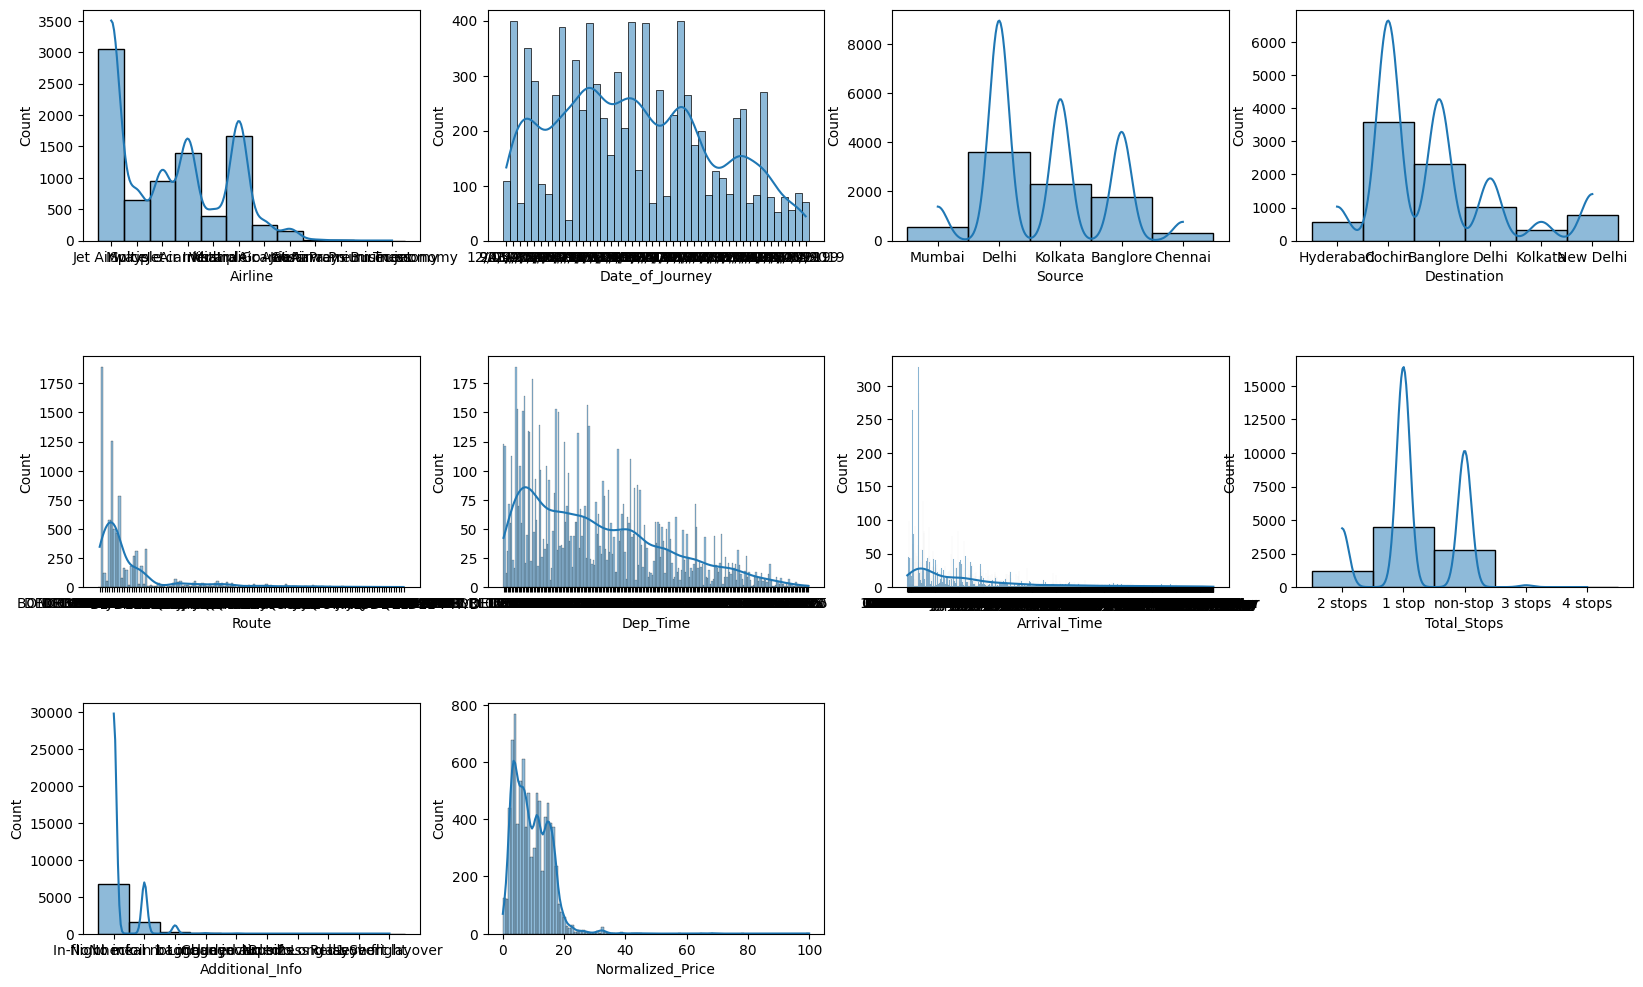

In [9]:
eda_analyzer.plot_histograms()

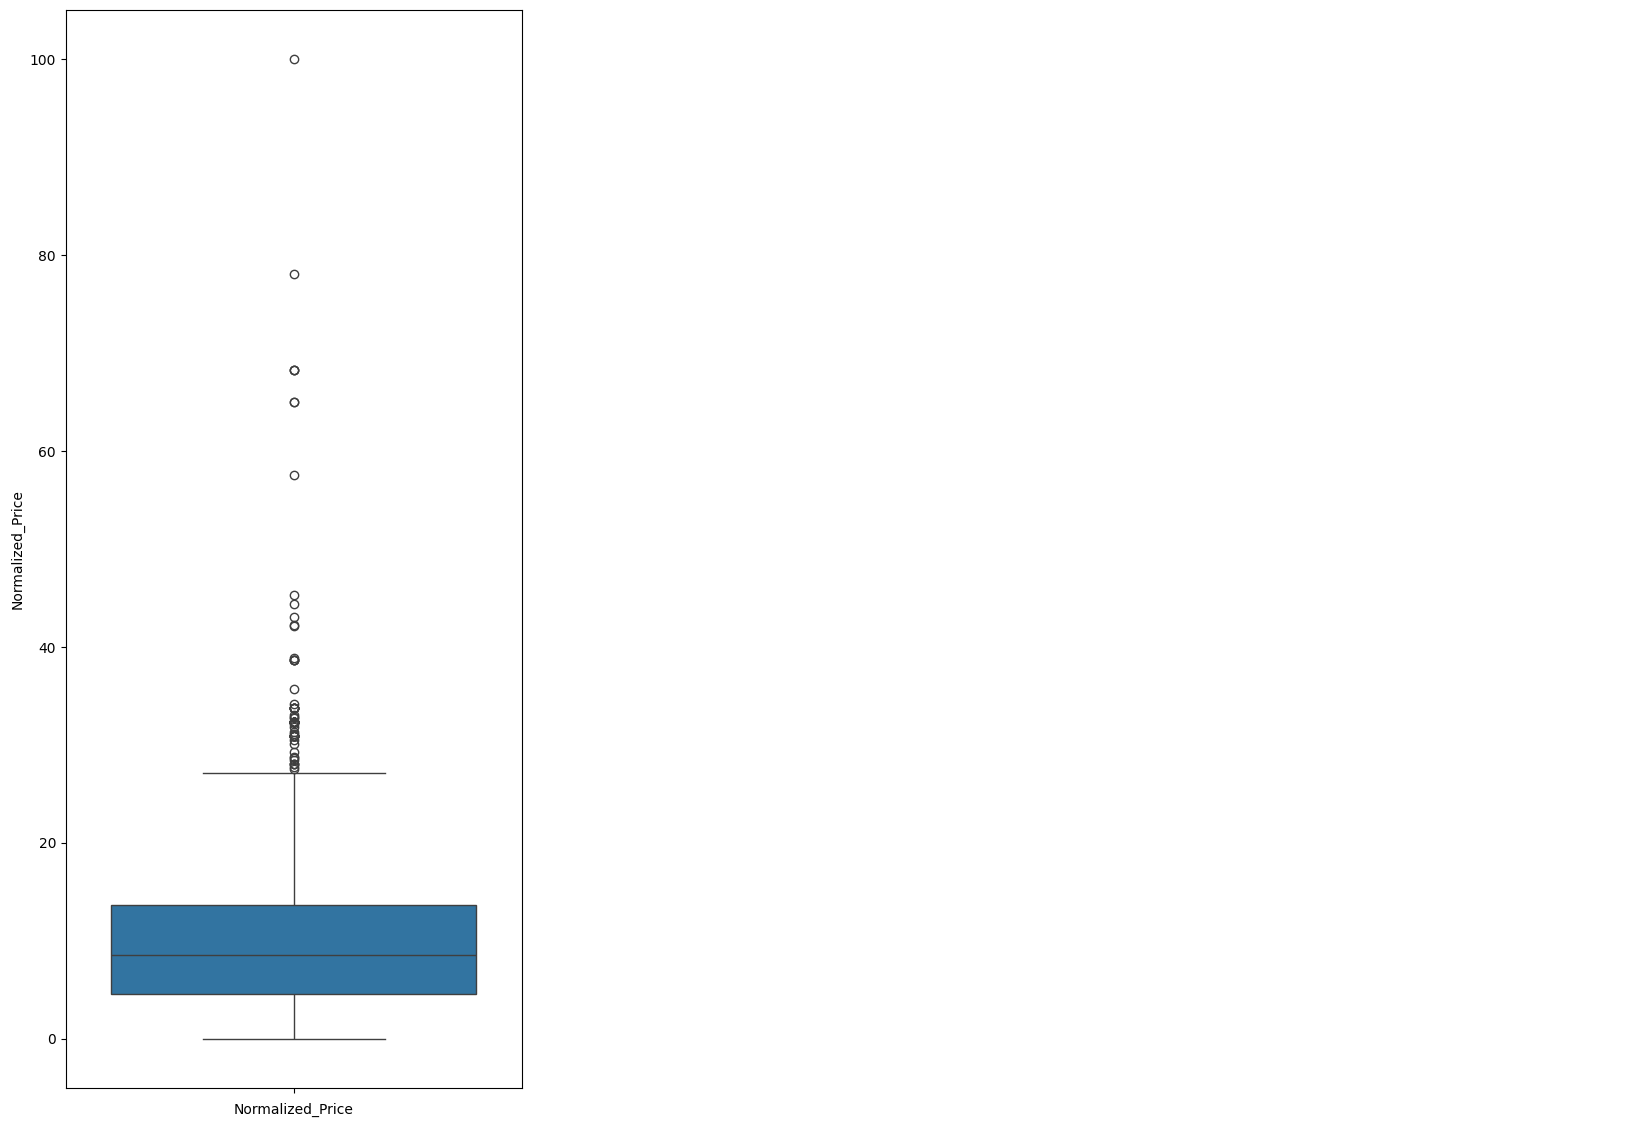

In [10]:
eda_analyzer.get_box_plot()

## Bivariate Analysis

 * We have no numeric data to plot against the target. We would do some feature engineering first and then we would redo the EDA again

#### Initial Data Quality Report : 
    * The data describes the flight journey of 12 airlines in India for 5 source locations and 6 destinations.
    * We can convert it to one hot encoding as some airlines can have an inherent price range.
    * The date ranges from 2019-03-01 00:00:00 to 2019-06-27 00:00:00, but its not continuous. There is a gap of 3 days in the dates
    * It's suggested to extract day features from it.
    * 5 source locations are represented in the data. Can do one hot encoding for the same as prices can be affected by city
    * 6 destination locations are represented in the data. Can do one hot encoding for the same as prices can be affected by city
    * departure time is represented as hh:mm and arrival time is represented as hh:mm and DD depending on if its the next day. This is an assumption made as this theory is validated by flight departure time and distance.
    * Stops represent the number of places it stopped before arriving to the destination
    * Additional info represents info such as meal inclusion, layover and class. The same can be converted to one hot encoding
    * null values are found in route and total stops
    
    
    


### Task 2 : 
    * Feature engineering: This step involves handling missing values, converting categorical variables into numerical representations, and performing feature engineering to extract useful information from the existing features.

### Feature Engineering

In [11]:
featureEngineer = FeatureEngineer(data)

* Column Processing  : Airline - We would convert this to one hot encoding as it isn't ordinal

In [12]:
eda_analyzer.get_unique_values_counts_for_column("Airline")

Airline  Count
0                         Jet Airways   3058
1                              IndiGo   1659
2                           Air India   1401
3                   Multiple carriers    953
4                            SpiceJet    654
5                             Vistara    389
6                            Air Asia    252
7                               GoAir    160
8   Multiple carriers Premium economy     13
9                Jet Airways Business      5
10            Vistara Premium economy      1
11                             Trujet      1

In [13]:
featureEngineer.add_one_hot_encoded_column("Airline")

In [14]:
featureEngineer.merge_data(airline_df,"Airline").head(2)

Airline Date_of_Journey  Source Destination                  Route  \
0  Jet Airways      12/03/2019  Mumbai   Hyderabad  BOM ? VNS ? DEL ? HYD   
1  Jet Airways       9/05/2019   Delhi      Cochin        DEL ? BOM ? COK   

  Dep_Time  Arrival_Time Total_Stops              Additional_Info  \
0    06:30         16:35     2 stops                      No info   
1    11:30  12:35 10 May      1 stop  In-flight meal not included   

   Normalized_Price  ...  Airline_Type  Airline_International  \
0         27.997634  ...             1                      1   
1         13.650920  ...             1                      1   

   Airline_Domestic  Airline_PremiumServices  Airline_LowCost  \
0                 1                        1                0   
1                 1                        1                0   

   Airline_FrequentFlyerProgram  Airline_InflightEntertainment  \
0                             1                              1   
1                             1                              1   

   Airline_LoungeAccess  Airline_WifiAvailability  Airline_OnboardMeals  
0                     1                         1                     1  
1                     1                         1                     1  

[2 rows x 32 columns]

* Column Processing  : 	Date_of_Journey  
     - We would extract information such as day of the week, 
     - day of the month, 
     - days before an holiday/vacation, 
     - oil prices

 - Day of the week

In [15]:
featureEngineer.add_day_of_week("Date_of_Journey")

Date_of_Journey_Day_of_Week Date_of_Journey
0                        Tuesday      2019-03-12
1                       Thursday      2019-05-09
2                      Wednesday      2019-04-24
3                       Thursday      2019-03-21
4                         Monday      2019-06-24
...                          ...             ...
8541                   Wednesday      2019-03-27
8542                    Thursday      2019-05-09
8543                   Wednesday      2019-05-15
8544                      Sunday      2019-03-03
8545                    Saturday      2019-06-01

[8546 rows x 2 columns]

In [16]:
featureEngineer.add_one_hot_encoded_column("Date_of_Journey_Day_of_Week")

In [17]:
featureEngineer.add_sinusoidal_day_of_week("Date_of_Journey")

Date_of_Journey_sin_day_of_week Date_of_Journey
0                            0.781831      2019-03-12
1                            0.433884      2019-05-09
2                            0.974928      2019-04-24
3                            0.433884      2019-03-21
4                            0.000000      2019-06-24
...                               ...             ...
8541                         0.974928      2019-03-27
8542                         0.433884      2019-05-09
8543                         0.974928      2019-05-15
8544                        -0.781831      2019-03-03
8545                        -0.974928      2019-06-01

[8546 rows x 2 columns]

 - Day of the month

In [18]:
featureEngineer.add_day_of_month("Date_of_Journey")

Date_of_Journey_Day_of_Month Date_of_Journey
0                               12      2019-03-12
1                                9      2019-05-09
2                               24      2019-04-24
3                               21      2019-03-21
4                               24      2019-06-24
...                            ...             ...
8541                            27      2019-03-27
8542                             9      2019-05-09
8543                            15      2019-05-15
8544                             3      2019-03-03
8545                             1      2019-06-01

[8546 rows x 2 columns]

In [19]:
featureEngineer.add_one_hot_encoded_column("Date_of_Journey_Day_of_Month")

In [20]:
featureEngineer.add_sinusoidal_day_of_month("Date_of_Journey")

Date_of_Journey_sin_day_of_month Date_of_Journey
0                             0.651372      2019-03-12
1                             0.968077      2019-05-09
2                            -0.988468      2019-04-24
3                            -0.897805      2019-03-21
4                            -0.988468      2019-06-24
...                                ...             ...
8541                         -0.724793      2019-03-27
8542                          0.968077      2019-05-09
8543                          0.101168      2019-05-15
8544                          0.571268      2019-03-03
8545                          0.201299      2019-06-01

[8546 rows x 2 columns]

 * Month of the Year for seasonality.

In [21]:
featureEngineer.add_month_of_year("Date_of_Journey")

Date_of_Journey_Month_of_Year Date_of_Journey
0                                 3      2019-03-12
1                                 5      2019-05-09
2                                 4      2019-04-24
3                                 3      2019-03-21
4                                 6      2019-06-24
...                             ...             ...
8541                              3      2019-03-27
8542                              5      2019-05-09
8543                              5      2019-05-15
8544                              3      2019-03-03
8545                              6      2019-06-01

[8546 rows x 2 columns]

In [22]:
featureEngineer.add_one_hot_encoded_column("Date_of_Journey_Month_of_Year")

In [23]:
featureEngineer.add_sinusoidal_month_of_year("Date_of_Journey")

Date_of_Journey_sin_month_of_year Date_of_Journey
0                          1.000000e+00      2019-03-12
1                          5.000000e-01      2019-05-09
2                          8.660254e-01      2019-04-24
3                          1.000000e+00      2019-03-21
4                          1.224647e-16      2019-06-24
...                                 ...             ...
8541                       1.000000e+00      2019-03-27
8542                       5.000000e-01      2019-05-09
8543                       5.000000e-01      2019-05-15
8544                       1.000000e+00      2019-03-03
8545                       1.224647e-16      2019-06-01

[8546 rows x 2 columns]

 * Add a feature to calculate the date difference between a holiday and date of journey

In [24]:
imp_dates = ["01/03/2019",
             "11/03/2019",
             "21/03/2019",
             "27/03/2019",
             "02/04/2019",
             "11/04/2019",
             "17/04/2019",
             "18/05/2019",
             "03/05/2019",
             "19/05/2019",
             "23/05/2019",
             "30/05/2019",
             "05/06/2019",
             "17/06/2019",
             "19/06/2019"]

In [25]:
featureEngineer.add_date_differences(imp_dates,10,"Date_of_Journey")

In [26]:
featureEngineer.merge_data(oil_df,"Date_of_Journey").head(1)

Airline Date_of_Journey  Source Destination                  Route  \
0  Jet Airways      2019-03-12  Mumbai   Hyderabad  BOM ? VNS ? DEL ? HYD   

  Dep_Time Arrival_Time Total_Stops Additional_Info  Normalized_Price  ...  \
0    06:30        16:35     2 stops         No info         27.997634  ...   

   days_before_30/05/2019  days_after_30/05/2019  days_before_05/06/2019  \
0                     NaN                    NaN                     NaN   

   days_after_05/06/2019  days_before_17/06/2019  days_after_17/06/2019  \
0                    NaN                     NaN                    NaN   

   days_before_19/06/2019  days_after_19/06/2019  Date_of_Journey_Oil_Price  \
0                     NaN                    NaN                    4432.04   

   Date_of_Journey_Oil_price_change  
0                              1.82  

[1 rows x 81 columns]

* Column Processing  : Source - We would convert this to one hot encoding as it isn't ordinal

In [27]:
eda_analyzer.get_unique_values_counts_for_column("Source")   

Source  Count
0     Delhi   3596
1   Kolkata   2312
2  Banglore   1777
3    Mumbai    555
4   Chennai    306

In [28]:
featureEngineer.merge_data(sourceAirportDetails_df,"Source").head(1)

Airline Date_of_Journey  Source Destination                  Route  \
0  Jet Airways      2019-03-12  Mumbai   Hyderabad  BOM ? VNS ? DEL ? HYD   

  Dep_Time Arrival_Time Total_Stops Additional_Info  Normalized_Price  ...  \
0    06:30        16:35     2 stops         No info         27.997634  ...   

   Source_Number_of_Destinations  Source_Scheduled_Flights_per_Day  \
0                          160.0                             800.0   

   Source_Cargo_Traffic(tons)  Source_International_Flights_Percentage  \
0                    180000.0                                     70.0   

   Source_Domestic_Flights_Percentage  Source_Longest_Runway_Length(km)  \
0                                30.0                               3.7   

   Source_Parking_Stands  Source_Passenger_Terminal_Area(sqkm)  \
0                   80.0                                   2.0   

   Source_Cargo_Terminal_Area(sqkm)  Source_Annual_Aircraft_Movements  
0                               1.8                          380000.0  

[1 rows x 94 columns]

In [29]:
featureEngineer.add_one_hot_encoded_column("Source")

* Column Processing  : Destination - We would convert this to one hot encoding as it isn't ordinal

In [30]:
eda_analyzer.get_unique_values_counts_for_column("Destination")

Destination  Count
0      Cochin   3596
1    Banglore   2312
2       Delhi   1017
3   New Delhi    760
4   Hyderabad    555
5     Kolkata    306

In [31]:
featureEngineer.merge_data(destinationAirportDetails_df,"Destination").head(1)

Airline Date_of_Journey  Source Destination                  Route  \
0  Jet Airways      2019-03-12  Mumbai   Hyderabad  BOM ? VNS ? DEL ? HYD   

  Dep_Time Arrival_Time Total_Stops Additional_Info  Normalized_Price  ...  \
0    06:30        16:35     2 stops         No info         27.997634  ...   

   Destination_Number_of_Destinations  Destination_Scheduled_Flights_per_Day  \
0                                70.0                                  350.0   

   Destination_Cargo_Traffic(tons)  \
0                          80000.0   

   Destination_International_Flights_Percentage  \
0                                          40.0   

   Destination_Domestic_Flights_Percentage  \
0                                     60.0   

   Destination_Longest_Runway_Length(km)  Destination_Parking_Stands  \
0                                    4.2                        70.0   

   Destination_Passenger_Terminal_Area(sqkm)  \
0                                        2.0   

   Destination_Cargo_Terminal_Area(sqkm)  \
0                                    1.2   

   Destination_Annual_Aircraft_Movements  
0                               180000.0  

[1 rows x 99 columns]

In [32]:
featureEngineer.add_one_hot_encoded_column("Destination")

* Column Processing  : Dep_Time - We would convert this to one hot encoding as it isn't ordinal after converting it to bins of 8

In [33]:
featureEngineer.make_time_bins("Dep_Time",8).head(3)

0    bin_2
1    bin_4
2    bin_5
Name: Dep_Time_Bin, dtype: category
Categories (8, object): ['bin_1' < 'bin_2' < 'bin_3' < 'bin_4' < 'bin_5' < 'bin_6' < 'bin_7' < 'bin_8']

In [34]:
featureEngineer.get_unique_values_counts_for_column("Dep_Time_Bin")

Dep_Time_Bin  Count
0        bin_3   1979
1        bin_7   1355
2        bin_6   1303
3        bin_2   1192
4        bin_5   1027
5        bin_4   1019
6        bin_8    433
7        bin_1    200

In [35]:
featureEngineer.add_one_hot_encoded_column("Dep_Time_Bin")

In [36]:
featureEngineer.add_sinusoidal_time("Dep_Time")

Dep_Time_sin_time Dep_Time
0          1.000000e+00    06:30
1          2.588190e-01    11:30
2         -1.707107e+00    15:45
3         -8.660254e-01    12:50
4          3.407417e-02    17:15
...                 ...      ...
8541       7.071068e-01    09:00
8542       1.665335e-16    14:05
8543      -8.660254e-01    12:50
8544      -8.660254e-01    00:40
8545      -2.588190e-01    13:00

[8546 rows x 2 columns]

* Column Processing  : Arrival_Time - We would convert this to one hot encoding as it isn't ordinal after converting it to bins of 8

In [37]:
featureEngineer.make_time_bins("Arrival_Time",8).head(3)

0    bin_6
1    bin_4
2    bin_8
Name: Arrival_Time_Bin, dtype: category
Categories (8, object): ['bin_1' < 'bin_2' < 'bin_3' < 'bin_4' < 'bin_5' < 'bin_6' < 'bin_7' < 'bin_8']

In [38]:
featureEngineer.get_unique_values_counts_for_column("Arrival_Time_Bin")

Arrival_Time_Bin  Count
0            bin_7   2161
1            bin_4   1338
2            bin_3   1111
3            bin_8    908
4            bin_6    873
5            bin_2    753
6            bin_5    613
7            bin_1    526

In [39]:
featureEngineer.add_one_hot_encoded_column("Arrival_Time_Bin")

In [40]:
featureEngineer.add_sinusoidal_time("Arrival_Time")

Arrival_Time_sin_time  Arrival_Time
0             -1.366025e+00         16:35
1             -5.000000e-01  12:35 10 May
2             -4.996004e-16         22:05
3             -2.411810e-01  01:35 22 Mar
4              3.407417e-02  19:15 25 Jun
...                     ...           ...
8541           1.366025e+00  04:25 28 Mar
8542          -1.866025e+00         20:45
8543           2.588190e-01  01:30 16 May
8544           1.207107e+00         03:25
8545           1.366025e+00  04:25 02 Jun

[8546 rows x 2 columns]

* Add a duration feature

In [41]:
featureEngineer.get_time_difference("Dep_Time","Arrival_Time").head(3)

0     605
1    1505
2     380
Name: Time_Difference_Minutes, dtype: int64

* Column Processing  : Total_Stops - We would convert this to one hot encoding as it isn't ordinal though it might sound not to. This is based on the context of different stop times and stoppages 

In [42]:
featureEngineer.get_unique_values_counts_for_column("Total_Stops")

Total_Stops  Count
0      1 stop   4509
1    non-stop   2794
2     2 stops   1203
3     3 stops     38
4     4 stops      1

In [43]:
featureEngineer.add_one_hot_encoded_column("Total_Stops")

* Column Processing  : Additional_Info - We would convert this to one hot encoding as it isn't ordinal 

In [44]:
featureEngineer.get_unique_values_counts_for_column("Additional_Info")

Additional_Info  Count
0                       No info   6704
1   In-flight meal not included   1562
2  No check-in baggage included    252
3                1 Long layover     14
4               Change airports      7
5                       No Info      2
6                Business class      2
7                2 Long layover      1
8                Red-eye flight      1
9               1 Short layover      1

In [45]:
featureEngineer.add_one_hot_encoded_column("Additional_Info")

* While processing the data and its features we also dealt with filling null values.

In [46]:
dataFeatureEngineered = featureEngineer.get_dataframe()
dataFeatureEngineered.shape

(8546, 129)

## Task 3: 
 * Perform EDA on the newly created data for selecting the features.

In [47]:
eda_analyzer = EDAAnalyzer(dataFeatureEngineered)
eda_analyzer.display_head()

Airline Date_of_Journey  Source Destination  \
0        Jet Airways      2019-03-12  Mumbai   Hyderabad   
1        Jet Airways      2019-05-09   Delhi      Cochin   
2           SpiceJet      2019-04-24   Delhi      Cochin   
3  Multiple carriers      2019-03-21   Delhi      Cochin   
4          Air India      2019-06-24   Delhi      Cochin   

                   Route Dep_Time  Arrival_Time Total_Stops  \
0  BOM ? VNS ? DEL ? HYD    06:30         16:35     2 stops   
1        DEL ? BOM ? COK    11:30  12:35 10 May      1 stop   
2        DEL ? MAA ? COK    15:45         22:05      1 stop   
3        DEL ? BOM ? COK    12:50  01:35 22 Mar      1 stop   
4  DEL ? HYD ? BOM ? COK    17:15  19:15 25 Jun     2 stops   

               Additional_Info  Normalized_Price  ...  \
0                      No info         27.997634  ...   
1  In-flight meal not included         13.650920  ...   
2                      No info          4.918138  ...   
3                      No info          7.634432  ...   
4                      No info         13.135184  ...   

   Additional_Info_1 Long layover  Additional_Info_1 Short layover  \
0                             0.0                              0.0   
1                             0.0                              0.0   
2                             0.0                              0.0   
3                             0.0                              0.0   
4                             0.0                              0.0   

   Additional_Info_2 Long layover  Additional_Info_Business class  \
0                             0.0                             0.0   
1                             0.0                             0.0   
2                             0.0                             0.0   
3                             0.0                             0.0   
4                             0.0                             0.0   

   Additional_Info_Change airports  \
0                              0.0   
1                              0.0   
2                              0.0   
3                              0.0   
4                              0.0   

   Additional_Info_In-flight meal not included  Additional_Info_No Info  \
0                                          0.0                      0.0   
1                                          1.0                      0.0   
2                                          0.0                      0.0   
3                                          0.0                      0.0   
4                                          0.0                      0.0   

   Additional_Info_No check-in baggage included  Additional_Info_No info  \
0                                           0.0                      1.0   
1                                           0.0                      0.0   
2                                           0.0                      1.0   
3                                           0.0                      1.0   
4                                           0.0                      1.0   

   Additional_Info_Red-eye flight  
0                             0.0  
1                             0.0  
2                             0.0  
3                             0.0  
4                             0.0  

[5 rows x 129 columns]

In [48]:
eda_analyzer.display_shape()

'Shape of data: rows: 8546 cols: 129'

In [49]:
eda_analyzer.describe()

count  \
Date_of_Journey                                 8546   
Normalized_Price                              8546.0   
Airline_Air Asia                              8546.0   
Airline_Air India                             8546.0   
Airline_GoAir                                 8546.0   
...                                              ...   
Additional_Info_In-flight meal not included   8546.0   
Additional_Info_No Info                       8546.0   
Additional_Info_No check-in baggage included  8546.0   
Additional_Info_No info                       8546.0   
Additional_Info_Red-eye flight                8546.0   

                                                                       mean  \
Date_of_Journey                               2019-05-04 21:50:55.745377792   
Normalized_Price                                                   9.409062   
Airline_Air Asia                                                   0.029487   
Airline_Air India                                                  0.163936   
Airline_GoAir                                                      0.018722   
...                                                                     ...   
Additional_Info_In-flight meal not included                        0.182776   
Additional_Info_No Info                                            0.000234   
Additional_Info_No check-in baggage included                       0.029487   
Additional_Info_No info                                            0.784461   
Additional_Info_Red-eye flight                                     0.000117   

                                                              min  \
Date_of_Journey                               2019-03-01 00:00:00   
Normalized_Price                                              0.0   
Airline_Air Asia                                              0.0   
Airline_Air India                                             0.0   
Airline_GoAir                                                 0.0   
...                                                           ...   
Additional_Info_In-flight meal not included                   0.0   
Additional_Info_No Info                                       0.0   
Additional_Info_No check-in baggage included                  0.0   
Additional_Info_No info                                       0.0   
Additional_Info_Red-eye flight                                0.0   

                                                              25%  \
Date_of_Journey                               2019-03-27 00:00:00   
Normalized_Price                                         4.515581   
Airline_Air Asia                                              0.0   
Airline_Air India                                             0.0   
Airline_GoAir                                                 0.0   
...                                                           ...   
Additional_Info_In-flight meal not included                   0.0   
Additional_Info_No Info                                       0.0   
Additional_Info_No check-in baggage included                  0.0   
Additional_Info_No info                                       1.0   
Additional_Info_Red-eye flight                                0.0   

                                                              50%  \
Date_of_Journey                               2019-05-15 00:00:00   
Normalized_Price                                         8.498707   
Airline_Air Asia                                              0.0   
Airline_Air India                                             0.0   
Airline_GoAir                                                 0.0   
...                                                           ...   
Additional_Info_In-flight meal not included                   0.0   
Additional_Info_No Info                                       0.0   
Additional_Info_No check-in baggage included                  0.0   
Additional_Info_No info                                       1.0   
Addition

### Univariate Analysis

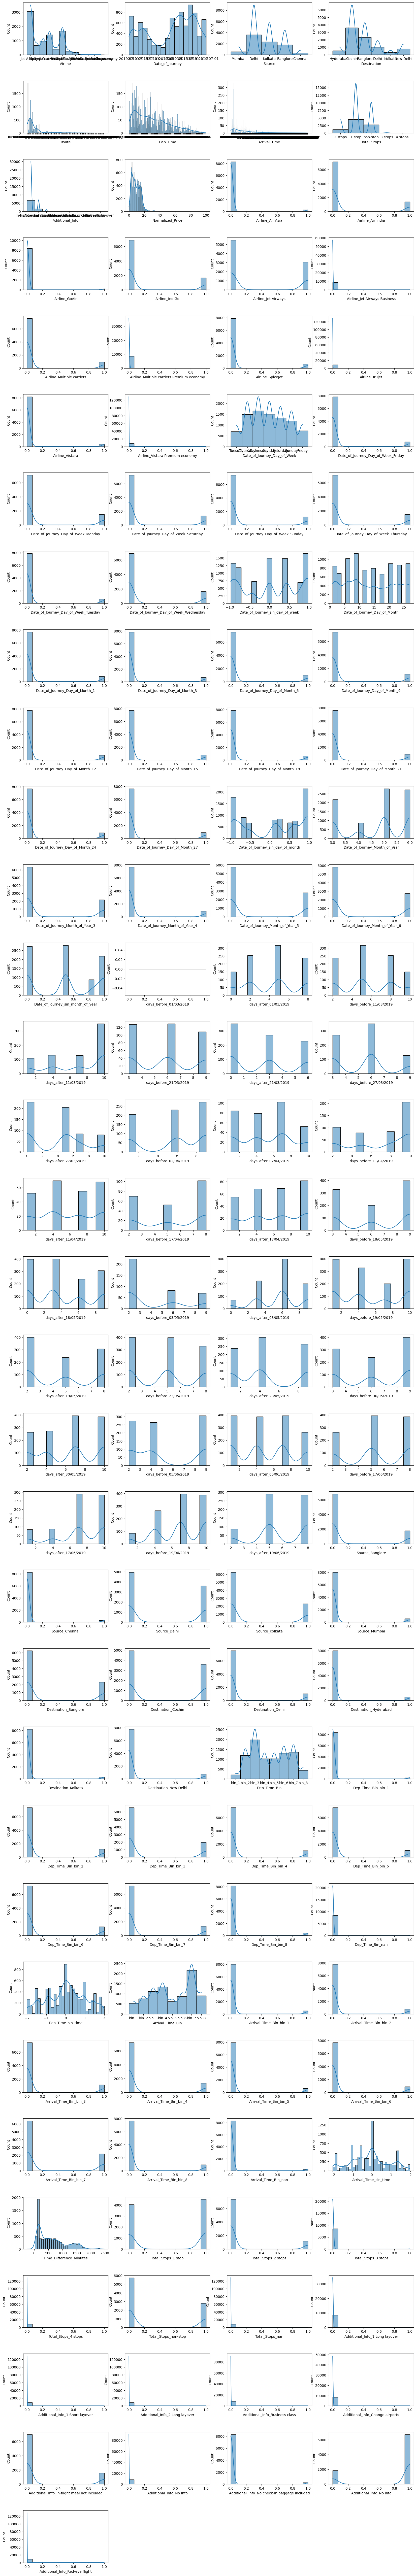

In [50]:
eda_analyzer.plot_histograms()

In [51]:
eda_analyzer.get_skew_kurt(ignore_columns=eda_analyzer.get_non_numeric_columns())

Column Name   Skewness     Kurtosis    Category
85                Dep_Time_Bin_bin_6   1.933888     1.740329   Inbetween
86                Dep_Time_Bin_bin_7   1.869938     1.497019   Inbetween
39            days_before_01/03/2019        NaN          NaN   Inbetween
34   Date_of_Journey_Month_of_Year_3   1.128109     0.727541   Inbetween
115          Additional_Info_No info   1.383819     0.085064   Inbetween
..                               ...        ...          ...         ...
78               Destination_Kolkata   4.997400    22.979385  Power Data
79             Destination_New Delhi   2.888819     6.346763  Power Data
80                Dep_Time_Bin_bin_1   6.306181    37.776764  Power Data
26   Date_of_Journey_Day_of_Month_12   2.901563     6.420570  Power Data
116   Additional_Info_Red-eye flight  92.444578  8546.000000  Power Data

[117 rows x 4 columns]

### Bivariate Analysis

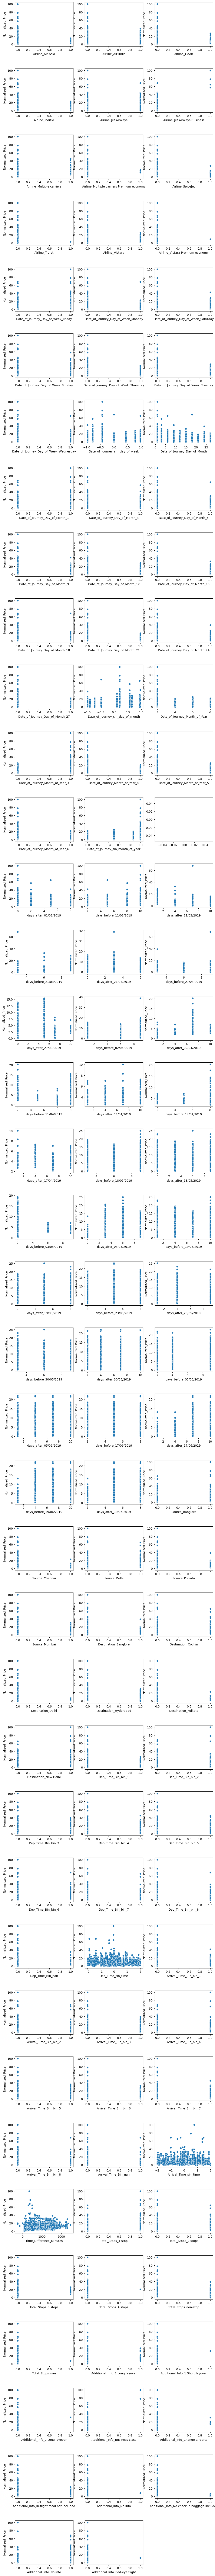

In [52]:
eda_analyzer.get_scatter_plot(y_cols=["Normalized_Price"])

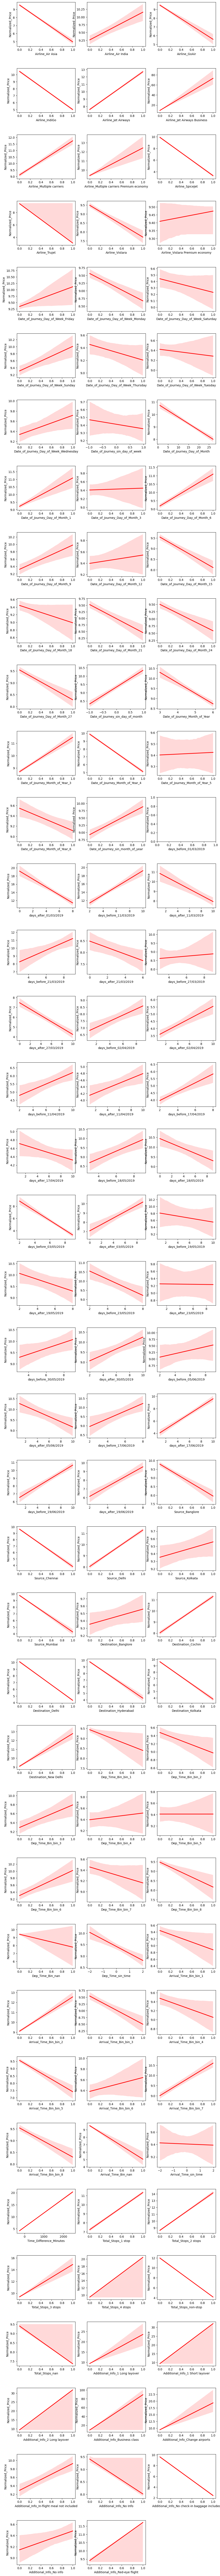

In [53]:
eda_analyzer.get_scatter_plot(y_cols=["Normalized_Price"],add_trend=True)

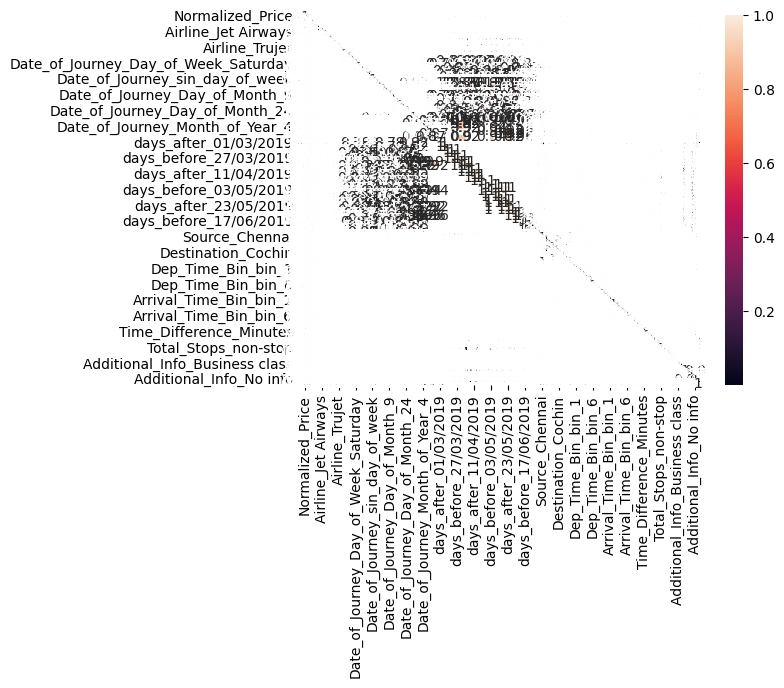

In [54]:
eda_analyzer.get_heat_map()

In [55]:
eda_analyzer.get_top_correlated_pairs()

Column 1                Column 2  \
2254  Date_of_Journey_Day_of_Month   days_after_11/04/2019   
4956         days_after_03/05/2019  days_before_19/05/2019   
2247  Date_of_Journey_Day_of_Month  days_before_21/03/2019   
4708         days_after_17/04/2019  days_before_03/05/2019   
2261  Date_of_Journey_Day_of_Month  days_before_19/05/2019   
2255  Date_of_Journey_Day_of_Month  days_before_17/04/2019   
5017        days_before_19/05/2019  days_before_23/05/2019   
2253  Date_of_Journey_Day_of_Month  days_before_11/04/2019   
2270  Date_of_Journey_Day_of_Month   days_after_17/06/2019   
4837         days_after_18/05/2019  days_before_23/05/2019   

      Correlation Coefficient Correlation Category  
2254                      1.0                 High  
4956                      1.0                 High  
2247                      1.0                 High  
4708                      1.0                 High  
2261                      1.0                 High  
2255                      1.0                 High  
5017                      1.0                 High  
2253                      1.0                 High  
2270                      1.0                 High  
4837                      1.0                 High

In [56]:
eda_analyzer.get_correlation_pairs()

Column 1  \
0                                 Normalized_Price   
1                                 Normalized_Price   
2                                 Normalized_Price   
3                                 Normalized_Price   
4                                 Normalized_Price   
...                                            ...   
6781                       Additional_Info_No Info   
6782                       Additional_Info_No Info   
6783  Additional_Info_No check-in baggage included   
6784  Additional_Info_No check-in baggage included   
6785                       Additional_Info_No info   

                            Column 2  Correlation Coefficient  \
0                   Airline_Air Asia                 0.130325   
1                  Airline_Air India                 0.055644   
2                      Airline_GoAir                 0.088946   
3                     Airline_IndiGo                 0.363521   
4                Airline_Jet Airways                 0.413318   
...                              ...                      ...   
6781         Additional_Info_No info                 0.029188   
6782  Additional_Info_Red-eye flight                 0.000166   
6783         Additional_Info_No info                 0.332537   
6784  Additional_Info_Red-eye flight                 0.001886   
6785  Additional_Info_Red-eye flight                 0.020638   

     Correlation Category  
0                     Low  
1                     Low  
2                     Low  
3                Moderate  
4                Moderate  
...                   ...  
6781                  Low  
6782                  Low  
6783             Moderate  
6784                  Low  
6785                  Low  

[6786 rows x 4 columns]

In [57]:
eda_analyzer.get_correlation_pairs().to_csv("./DC1Output/featureCorrelation.csv")

In [58]:
eda_analyzer.get_top_correlated_pairs_by_column(column_name="Normalized_Price")

Column 1                 Column 2  Correlation Coefficient  \
104  Normalized_Price     Total_Stops_non-stop                 0.616354   
99   Normalized_Price  Time_Difference_Minutes                 0.499163   
54   Normalized_Price   days_before_03/05/2019                 0.477537   
4    Normalized_Price      Airline_Jet Airways                 0.413318   
65   Normalized_Price    days_after_17/06/2019                 0.368391   
3    Normalized_Price           Airline_IndiGo                 0.363521   
100  Normalized_Price       Total_Stops_1 stop                 0.345203   
101  Normalized_Price      Total_Stops_2 stops                 0.323472   
75   Normalized_Price        Destination_Delhi                 0.313845   
40   Normalized_Price   days_before_11/03/2019                 0.307847   

    Correlation Category  
104             Moderate  
99              Moderate  
54              Moderate  
4               Moderate  
65              Moderate  
3               Moderate  
100             Moderate  
101             Moderate  
75              Moderate  
40              Moderate

 ### Feature Selection : 
    *  We have around 100 features, Lets decide what features we can go ahead and select.

* There are multiple ways we can select the features. Lets go with the approach of selecting the feature count from the feature importance we get after selecting the model to make ot stable. We go adeah for this way only cause the test is similar to train data and no feature show a clear sign of degradation of model performance , from the graphs


### Data Quality Report

#### Features highly Correlated with Normalized Price
- Total_Stops_non-stop
- Time_Difference_Minutes
- days_diff_21/03/2019
- Airline_Jet Airways
- days_diff_17/04/2019
- Airline_IndiGo
- Total_Stops_1 stop
- Total_Stops_2 stops
- Destination_Delhi

#### Observations
- Most variables are created with one hot encoding, resulting in a difference/slope in the bivariate data.
- The majority of variables follow a power distribution and a skewed normal.


* features for initial run

In [59]:
features = ['Total_Stops_non-stop',
'Time_Difference_Minutes',
'days_before_03/05/2019',
'Airline_Jet Airways',
'days_after_17/06/2019',
'Airline_IndiGo',
'Total_Stops_1 stop',
'Total_Stops_2 stops',
'Destination_Delhi',
'days_after_01/03/2019',
'days_before_11/03/2019',
'days_after_27/03/2019',
'Airline_SpiceJet',
'days_before_17/04/2019',
'Source_Delhi',
'Destination_Cochin',
'days_before_19/06/2019',
'days_after_02/04/2019',
'Airline_Jet Airways Business',
'Date_of_Journey_Month_of_Year_4',
'days_after_19/06/2019',
'Source_Mumbai',
'Destination_Hyderabad',
'Additional_Info_No check-in baggage included',
'Additional_Info_Business class',
'Date_of_Journey_Month_of_Year_3',
'days_after_11/03/2019',
'Source_Chennai',
'Destination_Kolkata',
'Destination_New Delhi',
'days_after_03/05/2019',
'days_after_11/04/2019',
'days_before_21/03/2019',
'Arrival_Time_Bin_bin_2',
'days_before_02/04/2019',
'days_before_11/04/2019',
'Date_of_Journey_Day_of_Month',
'Airline_Multiple carriers',
'Arrival_Time_Bin_nan',
'Airline_Air Asia',
'Date_of_Journey_sin_day_of_month',
'Source_Banglore',
'Arrival_Time_Bin_bin_7',
'days_before_18/05/2019',
'days_before_23/05/2019',
'days_after_17/04/2019',
'days_before_17/06/2019',
'Date_of_Journey_Day_of_Month_6',
'Date_of_Journey_Month_of_Year',
'Additional_Info_1 Long layover',
'days_after_30/05/2019',
'Arrival_Time_Bin_bin_5',
'Date_of_Journey_Day_of_Month_1',
'Airline_GoAir',
'days_after_05/06/2019',
'days_after_18/05/2019',
'days_after_21/03/2019',
'Date_of_Journey_Day_of_Month_15',
'Date_of_Journey_Day_of_Month_27',
'Arrival_Time_Bin_bin_8',
'days_after_19/05/2019',
'days_before_30/05/2019',
'Date_of_Journey_sin_month_of_year',
'Airline_Vistara',
'Total_Stops_3 stops',
'Arrival_Time_Bin_bin_3',
'Date_of_Journey_Day_of_Week_Monday',
'Airline_Air India',
'Date_of_Journey_Day_of_Month_21',
'Dep_Time_sin_time',
'Dep_Time_Bin_bin_8',
'Additional_Info_Change airports',
'Date_of_Journey_Day_of_Month_24',
'Dep_Time_Bin_bin_6',
'Additional_Info_1 Short layover',
'Additional_Info_In-flight meal not included',
'Additional_Info_2 Long layover',
'Date_of_Journey_Day_of_Week_Sunday',
'days_before_05/06/2019',
'Date_of_Journey_Day_of_Month_9',
'Date_of_Journey_Day_of_Week_Friday',
'Dep_Time_Bin_bin_3',
'Date_of_Journey_Month_of_Year_6',
'Dep_Time_Bin_bin_2',
'Dep_Time_Bin_bin_1',
'Arrival_Time_Bin_bin_4',
'Date_of_Journey_Day_of_Week_Wednesday',
'Additional_Info_No info',
'Arrival_Time_Bin_bin_1',
'days_before_19/05/2019',
'Date_of_Journey_Day_of_Month_18',
'Total_Stops_4 stops',
'Airline_Multiple carriers Premium economy',
'Dep_Time_Bin_nan',
'Dep_Time_Bin_bin_7',
'days_before_27/03/2019',
'Date_of_Journey_Day_of_Week_Thursday',
'Source_Kolkata',
'Destination_Banglore',
'Arrival_Time_Bin_bin_6',
'Date_of_Journey_Day_of_Week_Saturday',
'Airline_Trujet',
'Date_of_Journey_sin_day_of_week',
'Date_of_Journey_Day_of_Month_12',
'Dep_Time_Bin_bin_4',
'Date_of_Journey_Day_of_Week_Tuesday',
'Additional_Info_Red-eye flight',
'Total_Stops_nan',
'Additional_Info_No Info',
'Date_of_Journey_Day_of_Month_3',
'Date_of_Journey_Month_of_Year_5',
'days_after_23/05/2019',
'Arrival_Time_sin_time',
'Airline_Vistara Premium economy',
'Dep_Time_Bin_bin_5',
'days_before_01/03/2019']

### Feature engineering - Fill na with median, normalize the data


In [60]:
featureEngineer.fill_missing_values(feature_list=features,strategy='median').head(3)

Total_Stops_non-stop  Time_Difference_Minutes  days_before_03/05/2019  \
0                   0.0                      605                     2.0   
1                   0.0                     1505                     2.0   
2                   0.0                      380                     9.0   

   Airline_Jet Airways  days_after_17/06/2019  Airline_IndiGo  \
0                  1.0                    7.0             0.0   
1                  1.0                    7.0             0.0   
2                  0.0                    7.0             0.0   

   Total_Stops_1 stop  Total_Stops_2 stops  Destination_Delhi  \
0                 0.0                  1.0                0.0   
1                 1.0                  0.0                0.0   
2                 1.0                  0.0                0.0   

   days_after_01/03/2019  ...  Additional_Info_Red-eye flight  \
0                    5.0  ...                             0.0   
1                    5.0  ...                             0.0   
2                    5.0  ...                             0.0   

   Total_Stops_nan  Additional_Info_No Info  Date_of_Journey_Day_of_Month_3  \
0              0.0                      0.0                             0.0   
1              0.0                      0.0                             0.0   
2              0.0                      0.0                             0.0   

   Date_of_Journey_Month_of_Year_5  days_after_23/05/2019  \
0                              0.0                    4.0   
1                              1.0                    4.0   
2                              0.0                    4.0   

   Arrival_Time_sin_time  Airline_Vistara Premium economy  Dep_Time_Bin_bin_5  \
0          -1.366025e+00                              0.0                 0.0   
1          -5.000000e-01                              0.0                 0.0   
2          -4.996004e-16                              0.0                 1.0   

   days_before_01/03/2019  
0                     NaN  
1                     NaN  
2                     NaN  

[3 rows x 116 columns]

In [61]:
featureEngineer.fill_missing_values_with_zero(feature_list=features).head(3)

Total_Stops_non-stop  Time_Difference_Minutes  days_before_03/05/2019  \
0                   0.0                      605                     2.0   
1                   0.0                     1505                     2.0   
2                   0.0                      380                     9.0   

   Airline_Jet Airways  days_after_17/06/2019  Airline_IndiGo  \
0                  1.0                    7.0             0.0   
1                  1.0                    7.0             0.0   
2                  0.0                    7.0             0.0   

   Total_Stops_1 stop  Total_Stops_2 stops  Destination_Delhi  \
0                 0.0                  1.0                0.0   
1                 1.0                  0.0                0.0   
2                 1.0                  0.0                0.0   

   days_after_01/03/2019  ...  Additional_Info_Red-eye flight  \
0                    5.0  ...                             0.0   
1                    5.0  ...                             0.0   
2                    5.0  ...                             0.0   

   Total_Stops_nan  Additional_Info_No Info  Date_of_Journey_Day_of_Month_3  \
0              0.0                      0.0                             0.0   
1              0.0                      0.0                             0.0   
2              0.0                      0.0                             0.0   

   Date_of_Journey_Month_of_Year_5  days_after_23/05/2019  \
0                              0.0                    4.0   
1                              1.0                    4.0   
2                              0.0                    4.0   

   Arrival_Time_sin_time  Airline_Vistara Premium economy  Dep_Time_Bin_bin_5  \
0          -1.366025e+00                              0.0                 0.0   
1          -5.000000e-01                              0.0                 0.0   
2          -4.996004e-16                              0.0                 1.0   

   days_before_01/03/2019  
0                     0.0  
1                     0.0  
2                     0.0  

[3 rows x 116 columns]

In [62]:
featureEngineer.normalize_data(feature_list=features).head(3)

Total_Stops_non-stop  Time_Difference_Minutes  days_before_03/05/2019  \
0             -0.696953                -0.058557               -0.129123   
1             -0.696953                 1.740837               -0.129123   
2             -0.696953                -0.508406                9.395434   

   Airline_Jet Airways  days_after_17/06/2019  Airline_IndiGo  \
0             1.339641              -0.012214       -0.490804   
1             1.339641              -0.012214       -0.490804   
2            -0.746469              -0.012214       -0.490804   

   Total_Stops_1 stop  Total_Stops_2 stops  Destination_Delhi  \
0           -1.056844             2.470609          -0.367529   
1            0.946214            -0.404759          -0.367529   
2            0.946214            -0.404759          -0.367529   

   days_after_01/03/2019  ...  Additional_Info_Red-eye flight  \
0               0.095893  ...                       -0.010818   
1               0.095893  ...                       -0.010818   
2               0.095893  ...                       -0.010818   

   Total_Stops_nan  Additional_Info_No Info  Date_of_Journey_Day_of_Month_3  \
0        -0.010818                  -0.0153                       -0.294255   
1        -0.010818                  -0.0153                       -0.294255   
2        -0.010818                  -0.0153                       -0.294255   

   Date_of_Journey_Month_of_Year_5  days_after_23/05/2019  \
0                        -0.694731              -0.070284   
1                         1.439406              -0.070284   
2                        -0.694731              -0.070284   

   Arrival_Time_sin_time  Airline_Vistara Premium economy  Dep_Time_Bin_bin_5  \
0              -1.355895                        -0.010818           -0.369577   
1              -0.445411                        -0.010818           -0.369577   
2               0.080257                        -0.010818            2.705795   

   days_before_01/03/2019  
0                     0.0  
1                     0.0  
2                     0.0  

[3 rows x 116 columns]

### Feature engineering - Train test split 

In [63]:
train_x, test_x, train_y, test_y = featureEngineer.split_data(features,"Normalized_Price",test_size=0.2)

### Task 4: 
    * Develop the best regression model for predicting the price of airline tickets using the provided training dataset.
    * We would first train an ElasticNetModel with all features and hyperparameter tuning.
    * We then train the model again with top features and get the best model
    * Validate the same with the train we created from above

## ElasticNetModel

### Overview

The `ElasticNetModel` is a type of linear regression model that combines the properties of both Lasso and Ridge regression. It is particularly useful when dealing with high-dimensional datasets where feature selection and regularization are necessary.


In [64]:
elasticModel = ElasticNetModel(train_x, train_y, test_x, test_y)

In [65]:
elasticModel.hyperparameter_tuning(alphas=np.linspace(1e-2, 1, 5), l1_ratios=np.linspace(0, 1.0, 4),max_iter=np.linspace(1000, 1000, 1, dtype=int),tol=[1e-4])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.986e+04, tolerance: 1.873e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.026e+04, tolerance: 1.930e+01 Linear regression models with null weight for the l1 regularization term are mor

Alpha: 0.01, L1 Ratio: 0.0, Max Iter: 1000, Mean Squared Error: 7.6
Alpha: 0.01, L1 Ratio: 0.3333333333333333, Max Iter: 1000, Mean Squared Error: 7.71
Alpha: 0.01, L1 Ratio: 0.6666666666666666, Max Iter: 1000, Mean Squared Error: 8.05
Alpha: 0.01, L1 Ratio: 1.0, Max Iter: 1000, Mean Squared Error: 8.08
Alpha: 0.2575, L1 Ratio: 0.0, Max Iter: 1000, Mean Squared Error: 9.09
Alpha: 0.2575, L1 Ratio: 0.3333333333333333, Max Iter: 1000, Mean Squared Error: 9.83
Alpha: 0.2575, L1 Ratio: 0.6666666666666666, Max Iter: 1000, Mean Squared Error: 10.71
Alpha: 0.2575, L1 Ratio: 1.0, Max Iter: 1000, Mean Squared Error: 11.2
Alpha: 0.505, L1 Ratio: 0.0, Max Iter: 1000, Mean Squared Error: 10.21
Alpha: 0.505, L1 Ratio: 0.3333333333333333, Max Iter: 1000, Mean Squared Error: 11.51
Alpha: 0.505, L1 Ratio: 0.6666666666666666, Max Iter: 1000, Mean Squared Error: 12.88
Alpha: 0.505, L1 Ratio: 1.0, Max Iter: 1000, Mean Squared Error: 13.86
Alpha: 0.7525, L1 Ratio: 0.0, Max Iter: 1000, Mean Squared Error: 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.518e+04, tolerance: 2.398e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


In [66]:
elasticModel.print_best_hyperparameters()

Best Alpha: 0.01
Best L1 Ratio: 0.0
Best Max Iter: 1000
Best Mean Squared Error: 7.6


In [67]:
elasticModel.fit(l1_ratio=1, alpha=1e-2,max_iter=1000)

In [68]:
train_rse, train_prediction = elasticModel.predict_data(train_x,train_y)
print("Train RMSE : "+str(train_rse))

Train RMSE : 2.6582422280681315


In [69]:
test_rse, test_prediction = elasticModel.predict_data(test_x,test_y)
print("Test RMSE : "+str(test_rse))

Test RMSE : 3.056159150837458


In [70]:
elasticModel.get_feature_importance()

Importance
feature_3      2.469714
feature_79     2.404726
feature_0     -2.022586
feature_9     -1.698154
feature_96    -1.663243
...                 ...
feature_100   -0.000000
feature_103   -0.000000
feature_109    0.000000
feature_111    0.000000
feature_115    0.000000

[116 rows x 1 columns]

In [71]:
elasticModel.get_feature_importance().to_csv("./DC1Output/Feature_Importance.csv")

### Task 5 : 
 * Develop the regression model with best features for predicting based on the importance and correlation to the price of airline tickets using the provided training dataset.
 * We do it by altering different feature count and monitoring the train RSME

* Based on EDA and feature importance we select the below features :

#### Task 5 : Trial 1 
    * select top 55 features based on feature importance and correlation

In [72]:
features = ['Airline_Jet Airways',
'Date_of_Journey_Day_of_Month_9',
'Airline_Jet Airways Business',
'days_before_11/04/2019',
'Total_Stops_2 stops',
'Date_of_Journey_Day_of_Month_6',
'Date_of_Journey_Day_of_Week_Friday',
'Date_of_Journey_Day_of_Week_Tuesday',
'days_after_17/06/2019',
'Airline_Multiple carriers',
'days_before_02/04/2019',
'Date_of_Journey_Day_of_Month_27',
'days_after_03/05/2019',
'Date_of_Journey_Day_of_Week_Wednesday',
'Additional_Info_Business class',
'days_after_11/04/2019',
'days_after_27/03/2019',
'Date_of_Journey_Month_of_Year_3',
'days_after_02/04/2019',
'Date_of_Journey_Day_of_Month_18',
'Total_Stops_3 stops',
'Arrival_Time_Bin_nan',
'days_before_19/05/2019',
'Airline_Multiple carriers Premium economy',
'days_before_05/06/2019',
'Arrival_Time_Bin_bin_2',
'Dep_Time_Bin_bin_2',
'Arrival_Time_Bin_bin_6',
'Source_Banglore',
'Additional_Info_No Info',
'days_before_27/03/2019',
'days_after_18/05/2019',
'Arrival_Time_sin_time',
'Date_of_Journey_Day_of_Month_24',
'Arrival_Time_Bin_bin_8',
'Airline_GoAir',
'Date_of_Journey_Day_of_Week_Sunday',
'days_after_17/04/2019',
'Airline_Air Asia',
'Date_of_Journey_Day_of_Month_21',
'Date_of_Journey_Month_of_Year_4',
'Date_of_Journey_Month_of_Year_5',
'Source_Mumbai',
'days_before_17/04/2019',
'days_before_18/05/2019',
'Airline_SpiceJet',
'Date_of_Journey_Day_of_Month_15',
'days_after_05/06/2019',
'Airline_IndiGo',
'days_after_21/03/2019',
'Additional_Info_In-flight meal not included',
'days_before_17/06/2019',
'Date_of_Journey_Day_of_Week_Thursday',
'days_after_01/03/2019',
'Total_Stops_non-stop']

In [73]:
train_x, test_x, train_y, test_y = featureEngineer.split_data(features,"Normalized_Price",test_size=0.2)

In [74]:
elasticModel = ElasticNetModel(train_x, train_y, test_x, test_y)

In [75]:
elasticModel.hyperparameter_tuning(alphas=np.linspace(1e-2, 1, 5), l1_ratios=np.linspace(0, 1.0, 4),max_iter=np.linspace(1000, 1000, 1, dtype=int),tol=[1e-4])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.202e+04, tolerance: 1.890e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.158e+04, tolerance: 1.916e+01 Linear regression models with null weight for the l1 regularization term are mor

Alpha: 0.01, L1 Ratio: 0.0, Max Iter: 1000, Mean Squared Error: 8.27
Alpha: 0.01, L1 Ratio: 0.3333333333333333, Max Iter: 1000, Mean Squared Error: 8.27
Alpha: 0.01, L1 Ratio: 0.6666666666666666, Max Iter: 1000, Mean Squared Error: 8.27
Alpha: 0.01, L1 Ratio: 1.0, Max Iter: 1000, Mean Squared Error: 8.27
Alpha: 0.2575, L1 Ratio: 0.0, Max Iter: 1000, Mean Squared Error: 9.94
Alpha: 0.2575, L1 Ratio: 0.3333333333333333, Max Iter: 1000, Mean Squared Error: 10.44
Alpha: 0.2575, L1 Ratio: 0.6666666666666666, Max Iter: 1000, Mean Squared Error: 10.88
Alpha: 0.2575, L1 Ratio: 1.0, Max Iter: 1000, Mean Squared Error: 11.37
Alpha: 0.505, L1 Ratio: 0.0, Max Iter: 1000, Mean Squared Error: 11.43
Alpha: 0.505, L1 Ratio: 0.3333333333333333, Max Iter: 1000, Mean Squared Error: 12.37
Alpha: 0.505, L1 Ratio: 0.6666666666666666, Max Iter: 1000, Mean Squared Error: 13.38
Alpha: 0.505, L1 Ratio: 1.0, Max Iter: 1000, Mean Squared Error: 14.13
Alpha: 0.7525, L1 Ratio: 0.0, Max Iter: 1000, Mean Squared Erro

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.862e+04, tolerance: 2.426e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


In [76]:
elasticModel.print_best_hyperparameters()

Best Alpha: 0.01
Best L1 Ratio: 0.0
Best Max Iter: 1000
Best Mean Squared Error: 8.27


In [77]:
elasticModel.fit(l1_ratio=0.1, alpha=0.01,max_iter=1000)

In [78]:
train_rse, train_prediction = elasticModel.predict_data(train_x,train_y)
print("Train RSE : "+str(train_rse))

Train RSE : 2.826174220882732


In [79]:
test_rse, test_prediction = elasticModel.predict_data(test_x,test_y)
print("Test RSE : "+str(test_rse))

Test RSE : 2.4782403112974434


#### Task 5 : Trial 2 
    * Clean the data and select top 55 features based on feature importance and correlation

In [80]:
train_x_clean, test_x_clean, train_y_clean, test_y_clean = featureEngineer.split_data_clean(features,"Normalized_Price",test_size=0.2)

Number of rows removed: 8539


In [81]:
elasticModel = ElasticNetModel(train_x_clean, train_y_clean, test_x_clean, test_y_clean)

In [82]:
elasticModel.hyperparameter_tuning(alphas=np.linspace(0.0001, 1, 5), l1_ratios=np.linspace(0.1, 1.0, 4),max_iter=np.linspace(1000, 10000, 2, dtype=int),tol=[1e-4])

Alpha: 0.0001, L1 Ratio: 0.1, Max Iter: 1000, Mean Squared Error: 0.92
Alpha: 0.0001, L1 Ratio: 0.1, Max Iter: 10000, Mean Squared Error: 0.92
Alpha: 0.0001, L1 Ratio: 0.4, Max Iter: 1000, Mean Squared Error: 0.92
Alpha: 0.0001, L1 Ratio: 0.4, Max Iter: 10000, Mean Squared Error: 0.92
Alpha: 0.0001, L1 Ratio: 0.7, Max Iter: 1000, Mean Squared Error: 0.92
Alpha: 0.0001, L1 Ratio: 0.7, Max Iter: 10000, Mean Squared Error: 0.92
Alpha: 0.0001, L1 Ratio: 1.0, Max Iter: 1000, Mean Squared Error: 0.92
Alpha: 0.0001, L1 Ratio: 1.0, Max Iter: 10000, Mean Squared Error: 0.92
Alpha: 0.250075, L1 Ratio: 0.1, Max Iter: 1000, Mean Squared Error: 0.92
Alpha: 0.250075, L1 Ratio: 0.1, Max Iter: 10000, Mean Squared Error: 0.92
Alpha: 0.250075, L1 Ratio: 0.4, Max Iter: 1000, Mean Squared Error: 0.92
Alpha: 0.250075, L1 Ratio: 0.4, Max Iter: 10000, Mean Squared Error: 0.92
Alpha: 0.250075, L1 Ratio: 0.7, Max Iter: 1000, Mean Squared Error: 0.92
Alpha: 0.250075, L1 Ratio: 0.7, Max Iter: 10000, Mean Squared

In [83]:
elasticModel.print_best_hyperparameters()

Best Alpha: 0.0001
Best L1 Ratio: 0.1
Best Max Iter: 1000
Best Mean Squared Error: 0.92


In [84]:
elasticModel.fit(l1_ratio=0.7, alpha=0.0001,max_iter=1000)

In [85]:
train_rse_clean, train_prediction_clean = elasticModel.predict_data(train_x_clean,train_y_clean)
print("Train RSE : "+str(train_rse_clean))

Train RSE : 0.7668618986020053


In [86]:
test_rse_clean, test_prediction_clean = elasticModel.predict_data(test_x_clean,test_y_clean)
print("Test RSE : "+str(test_rse))

Test RSE : 2.4782403112974434


In [87]:
train_rse_clean, train_prediction_clean = elasticModel.predict_data(train_x,train_y)
print("Train RSE : "+str(train_rse))

Train RSE : 2.826174220882732


In [88]:
test_rse_clean, test_prediction_clean = elasticModel.predict_data(test_x,test_y)
print("Train RSE : "+str(test_rse))

Train RSE : 2.4782403112974434


#### Task 5 : Trial 3
    * Reduce the feature further and try again

In [89]:
features = ['Airline_Jet Airways',
'Date_of_Journey_Day_of_Month_9',
'Airline_Jet Airways Business',
'days_before_11/04/2019',
'Total_Stops_2 stops',
'Date_of_Journey_Day_of_Month_6',
'Date_of_Journey_Day_of_Week_Friday',
'Date_of_Journey_Day_of_Week_Tuesday',
'days_after_17/06/2019',
'Airline_Multiple carriers',
'days_before_02/04/2019',
'Date_of_Journey_Day_of_Month_27',
'days_after_03/05/2019',
'Date_of_Journey_Day_of_Week_Wednesday',
'Additional_Info_Business class',
'days_after_11/04/2019',
'days_after_27/03/2019',
'Date_of_Journey_Month_of_Year_3',
'days_after_02/04/2019',
'Date_of_Journey_Day_of_Month_18',
'Total_Stops_3 stops',
'Arrival_Time_Bin_nan',
'days_before_19/05/2019',
'Airline_Multiple carriers Premium economy',
'days_before_05/06/2019',
'Arrival_Time_Bin_bin_2',
'Dep_Time_Bin_bin_2',
'Arrival_Time_Bin_bin_6',
'Source_Banglore',
'Additional_Info_No Info',
'days_before_27/03/2019',
'days_after_18/05/2019']

In [90]:
train_x, test_x, train_y, test_y = featureEngineer.split_data(features,"Normalized_Price",test_size=0.2)

In [91]:
elasticModel = ElasticNetModel(train_x, train_y, test_x, test_y)

In [92]:
elasticModel.hyperparameter_tuning(alphas=np.linspace(0.0001, 1, 5), l1_ratios=np.linspace(0.1, 1.0, 4),max_iter=np.linspace(1000, 10000, 2, dtype=int),tol=[1e-4])

Alpha: 0.0001, L1 Ratio: 0.1, Max Iter: 1000, Mean Squared Error: 16.49
Alpha: 0.0001, L1 Ratio: 0.1, Max Iter: 10000, Mean Squared Error: 16.49
Alpha: 0.0001, L1 Ratio: 0.4, Max Iter: 1000, Mean Squared Error: 16.49
Alpha: 0.0001, L1 Ratio: 0.4, Max Iter: 10000, Mean Squared Error: 16.49
Alpha: 0.0001, L1 Ratio: 0.7, Max Iter: 1000, Mean Squared Error: 16.49
Alpha: 0.0001, L1 Ratio: 0.7, Max Iter: 10000, Mean Squared Error: 16.49
Alpha: 0.0001, L1 Ratio: 1.0, Max Iter: 1000, Mean Squared Error: 16.49
Alpha: 0.0001, L1 Ratio: 1.0, Max Iter: 10000, Mean Squared Error: 16.49
Alpha: 0.250075, L1 Ratio: 0.1, Max Iter: 1000, Mean Squared Error: 17.6
Alpha: 0.250075, L1 Ratio: 0.1, Max Iter: 10000, Mean Squared Error: 17.6
Alpha: 0.250075, L1 Ratio: 0.4, Max Iter: 1000, Mean Squared Error: 17.83
Alpha: 0.250075, L1 Ratio: 0.4, Max Iter: 10000, Mean Squared Error: 17.83
Alpha: 0.250075, L1 Ratio: 0.7, Max Iter: 1000, Mean Squared Error: 18.11
Alpha: 0.250075, L1 Ratio: 0.7, Max Iter: 10000, M

In [93]:
elasticModel.print_best_hyperparameters()

Best Alpha: 0.0001
Best L1 Ratio: 0.1
Best Max Iter: 1000
Best Mean Squared Error: 16.49


In [94]:
elasticModel.fit(l1_ratio=0.7, alpha=0.0001,max_iter=10000)

In [95]:
train_rse, train_prediction = elasticModel.predict_data(train_x,train_y)
print("Train RMSE : "+str(train_rse))

Train RMSE : 4.029045786202834


In [96]:
test_rse, test_prediction = elasticModel.predict_data(test_x,test_y)
print("Test RMSE : "+str(test_rse))

Test RMSE : 4.361750462679295


#### Conclusion
**Task 5**: Regression Model Development (Best Features):
- **Trial 1**: Test with top features based on correlation and importance.
- **Trial 2**: Test with top features based on correlation and importance, and remove outliers.
- **Trial 3**: Test with fewer top features based on correlation and importance.

- The above testing was conducted, and both trial 1 and trial 2 resulted in the same root mean square error (RMSE). However, trial 3, which experimented with fewer features, showed a decreased RMSE.
- Consequently, we opt for the model from trial one.
- The model comprises 55 features with the following combination: `l1_ratio=0.1`, `alpha=0.01`, `max_iter=1000`.


### Task 6: 
    * Generate Model: Use the provided config to generate model 

In [116]:
features = ['Airline_Jet Airways',
'Date_of_Journey_Day_of_Month_9',
'Airline_Jet Airways Business',
'days_before_11/04/2019',
'Total_Stops_2 stops',
'Date_of_Journey_Day_of_Month_6',
'Date_of_Journey_Day_of_Week_Friday',
'Date_of_Journey_Day_of_Week_Tuesday',
'days_after_17/06/2019',
'Airline_Multiple carriers',
'days_before_02/04/2019',
'Date_of_Journey_Day_of_Month_27',
'days_after_03/05/2019',
'Date_of_Journey_Day_of_Week_Wednesday',
'Additional_Info_Business class',
'days_after_11/04/2019',
'days_after_27/03/2019',
'Date_of_Journey_Month_of_Year_3',
'days_after_02/04/2019',
'Date_of_Journey_Day_of_Month_18',
'Total_Stops_3 stops',
'Arrival_Time_Bin_nan',
'days_before_19/05/2019',
'Airline_Multiple carriers Premium economy',
'days_before_05/06/2019',
'Arrival_Time_Bin_bin_2',
'Dep_Time_Bin_bin_2',
'Arrival_Time_Bin_bin_6',
'Source_Banglore',
'Additional_Info_No Info',
'days_before_27/03/2019',
'days_after_18/05/2019',
'Arrival_Time_sin_time',
'Date_of_Journey_Day_of_Month_24',
'Arrival_Time_Bin_bin_8',
'Airline_GoAir',
'Date_of_Journey_Day_of_Week_Sunday',
'days_after_17/04/2019',
'Airline_Air Asia',
'Date_of_Journey_Day_of_Month_21',
'Date_of_Journey_Month_of_Year_4',
'Date_of_Journey_Month_of_Year_5',
'Source_Mumbai',
'days_before_17/04/2019',
'days_before_18/05/2019',
'Airline_SpiceJet',
'Date_of_Journey_Day_of_Month_15',
'days_after_05/06/2019',
'Airline_IndiGo',
'days_after_21/03/2019',
'Additional_Info_In-flight meal not included',
'days_before_17/06/2019',
'Date_of_Journey_Day_of_Week_Thursday',
'days_after_01/03/2019',
'Total_Stops_non-stop']

In [117]:
train_x, test_x, train_y, test_y = featureEngineer.split_data(features,"Normalized_Price",test_size=0.2)

In [118]:
elasticModel = ElasticNetModel(train_x, train_y, test_x, test_y)

In [119]:
elasticModel.fit(l1_ratio=0.1, alpha=0.01,max_iter=1000)

In [120]:
train_rse, train_prediction = elasticModel.predict_data(train_x,train_y)
print("Train RMSE : "+str(train_rse))

Train RMSE : 2.767094524251318


In [121]:
test_rse, test_prediction = elasticModel.predict_data(test_x,test_y)
print("Test RMSE : "+str(test_rse))

Test RMSE : 2.759140440031113


In [122]:
elasticModel.save_model()

Model saved successfully at: elastic_net_model.pkl
